In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from math import log

In [2]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt
from alignment_utils import tokenize_mr, tokenize_mr_upper
from data_processing import Delexicalizer
from slot_aligner import SlotAligner
from alignment_utils import tokenize_mr, tokenize_mr_upper
aligner = SlotAligner()

delexicalizer = Delexicalizer("partial", ["name", "near", "food"])

chencherry = bleu_score.SmoothingFunction()

In [3]:
def beam_search_decoder(data, k):
    sequences = [[list(), 1.0]]
    
    # walk over each generated word
    for row in data:
        
        all_candidates = list()
        
        # expand each current candidate
        for i in range(len(sequences)):
            
            # All sequences preserved by the search until now
            seq, score = sequences[i]
            
            # Iterate over all possible options for this word
            for j in range(len(row)):
                
                # Create a new candidate by multiplying the previous score and the new score
                candidate = [seq + [j], score * row[j]]
                
                # Append the new candidate to the list of all candidates
                all_candidates.append(candidate)
                
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)

        # select k best candidates
        sequences = ordered[:k]
    return sequences

In [32]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        
        self.model = model
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            # To fix the sampling probability to 0
                            target_sequence=batch_dict['x_target'],
                            sample_probability=1.0)
        self._last_batch['y_pred'] = y_pred
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_gt_mrs(self, index):
        inp_mr = self._last_batch['inp_gt'][index]
        return inp_mr
    
    def _get_gt_ref(self, index):
        ref_gt = self._last_batch['ref_gt'][index]
        return ref_gt
    
    def _get_sampled_sentence(self, index, return_string=True):
        vocab = self.vectorizer.target_vocab
        prob_res = torch.nn.functional.softmax(self._last_batch['y_pred'], dim=2)
        sentece_probs = prob_res[index].cpu().detach().numpy()
        
        top_sequences = beam_search_decoder(sentece_probs, 3)

        top = []
        gt_mr = tokenize_mr(self._last_batch['inp_gt'][index])
        res_after_reranking = []
        # Iterate over all produced sequences
        for sequence in top_sequences:
            sent_str = sentence_from_indices(sequence[0], vocab, return_string=True)
            reranker_score = aligner.alignment_reranker(gt_mr, sent_str)
            res_after_reranking.append(sequence[1])#*reranker_score)
            top.append(sent_str)
        
        max_seq_idx = res_after_reranking.index(max(res_after_reranking))
        sentence_indices = top_sequences[max_seq_idx][0]
        
        print("Making a prediction {}".format(index))
        
        #Old code
#         # Here the beam search and the reranker should be included
#         prob_res = torch.nn.functional.softmax(self._last_batch['y_pred'], dim=2)
        
#         # Maximize the results, so the indices are applied
#         #_, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        
#         #Use softmax before maximization
#         _, all_indices = torch.max(prob_res, dim=2)

#         sentence_indices = all_indices[index].cpu().detach().numpy()
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        sampled_sentence = self._get_sampled_sentence(index, return_string=return_string)
        gt_mrs = self._get_gt_mrs(index)
        ref_gt = self._get_gt_ref(index)
        
        sampled_normalized = delexicalizer.reverse_delexicalize_sample(gt_mrs, " ".join(sampled_sentence))
        
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": sampled_sentence,
                  "attention": self._last_batch['attention'][index],
                  "sampled_normalized":sampled_normalized,
                  "reference_gt":ref_gt,
                  "mrs_gt":gt_mrs,
                  "y_target": self._last_batch['y_target'][index]
                 }
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [33]:
args = Namespace(dataset_csv="data/inp_and_gt.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 save_dir="data/model_storage/",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=32,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=24, 
                 target_embedding_size=24,
                 encoding_size=32,
                 catch_keyboard_interrupt=True)

In [34]:
from encoders import NMTEncoder
from decoders import NMTDecoder
from data_loader import NMTDataset, generate_nmt_batches
from models import NMTModel
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

np.random.seed(1337)
torch.manual_seed(1337)

torch.cuda.manual_seed_all(1337)
    
args.device = torch.device("cuda" if args.cuda else "cpu")

dataset = NMTDataset.load_dataset_and_load_vectorizer("data/inp_and_gt.csv",
                                                          "data/model_storage/vectorizer.json")
vectorizer = dataset.get_vectorizer()
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

model.load_state_dict(torch.load(args.save_dir+args.model_state_file))
model.eval().to(args.device)


sampler = NMTSampler(vectorizer, model)
dataset.set_split('val')

batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device,
                                       shuffle=True)

#Contains the samples for the current batch
batch_dict = next(batch_generator)

# model = model.eval().to(args.device)
# sampler = NMTSampler(vectorizer, model)

# Apply the sampler to the batch
sampler.apply_to_batch(batch_dict)

Inputs are equal
False
After embedding
False
The outputs of the last layer
False
The last hidden states
False
Hidden states are equal after the map
False
After taking the target embeddings: 
True
Before taking the GRU step: 
True
After taking a GRU step: 
False
After going through the attention: 
False
After running the classifier: 
False
After going the softmax layers: 
False
torch.Size([32, 2894])
After taking the index of the predicted word: 
True
torch.Size([32])
#######################################
After taking the target embeddings: 
True
Before taking the GRU step: 
False
After taking a GRU step: 
False
After going through the attention: 
False
After running the classifier: 
False
After going the softmax layers: 
False
torch.Size([32, 2894])
After taking the index of the predicted word: 
True
torch.Size([32])
#######################################
After taking the target embeddings: 
True
Before taking the GRU step: 
False
After taking a GRU step: 
False
After going through 

In [35]:
all_results = []
#args.batch_size
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

Making a prediction 0
Making a prediction 1
Making a prediction 2
Making a prediction 3
Making a prediction 4
Making a prediction 5
Making a prediction 6
Making a prediction 7
Making a prediction 8
Making a prediction 9
Making a prediction 10
Making a prediction 11
Making a prediction 12
Making a prediction 13
Making a prediction 14
Making a prediction 15
Making a prediction 16
Making a prediction 17
Making a prediction 18
Making a prediction 19
Making a prediction 20
Making a prediction 21
Making a prediction 22
Making a prediction 23
Making a prediction 24
Making a prediction 25
Making a prediction 26
Making a prediction 27
Making a prediction 28
Making a prediction 29
Making a prediction 30
Making a prediction 31


In [36]:
len(all_results)
len(vectorizer.target_vocab)

2894

In [37]:
top_results = [x for x in all_results if x['bleu-4']>0.5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


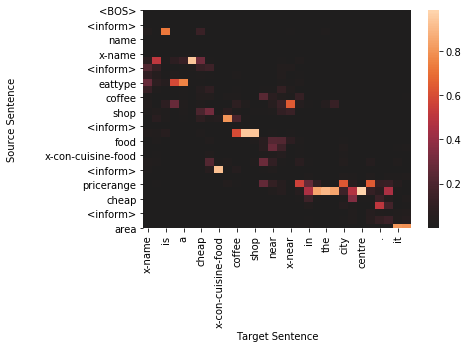

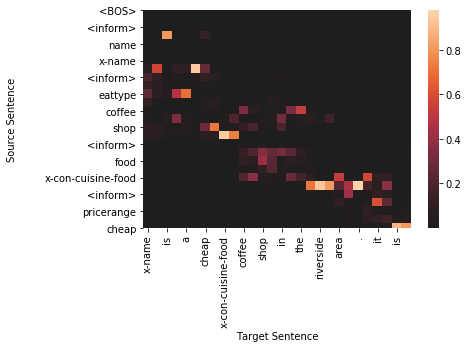

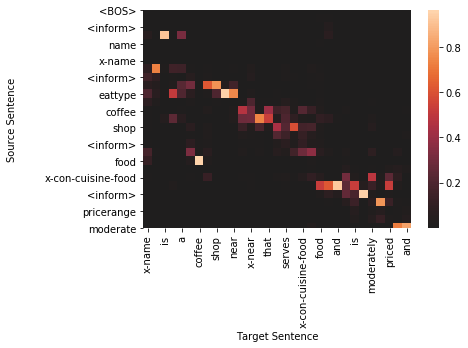

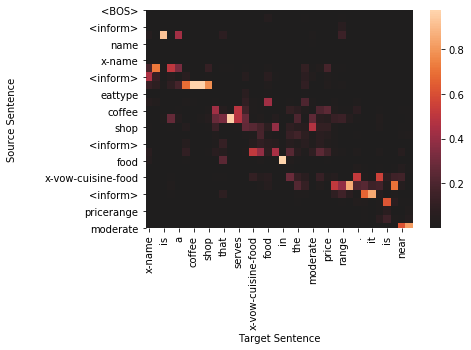

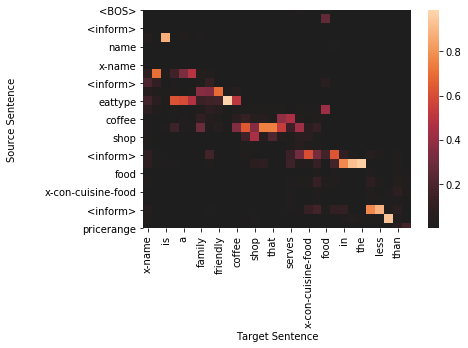

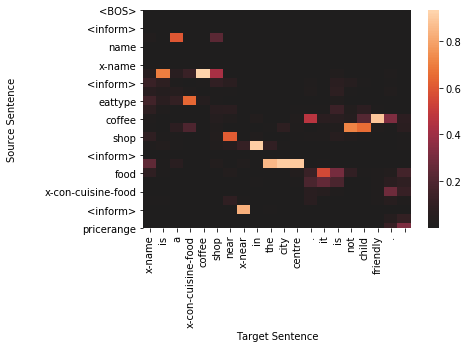

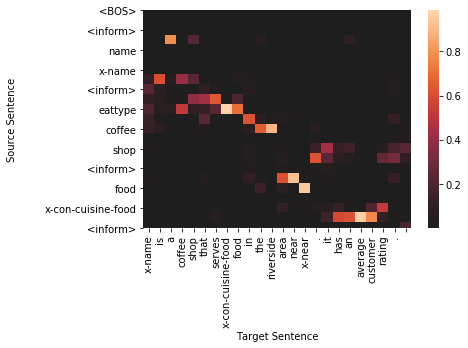

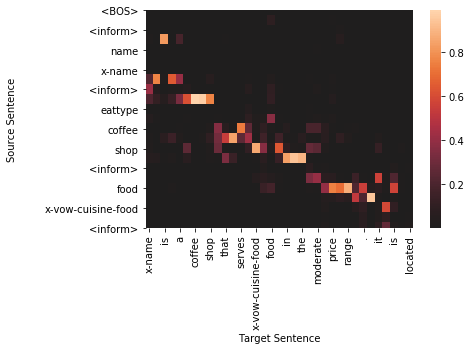

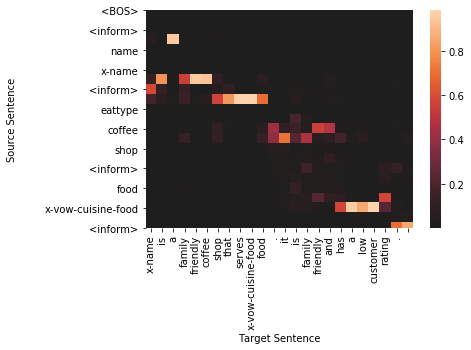

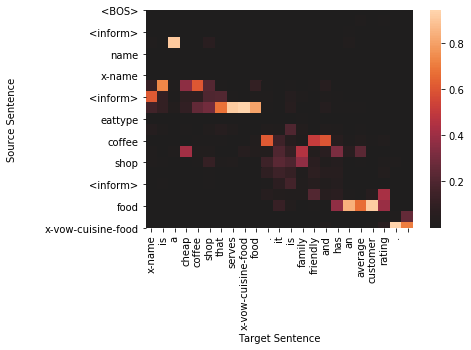

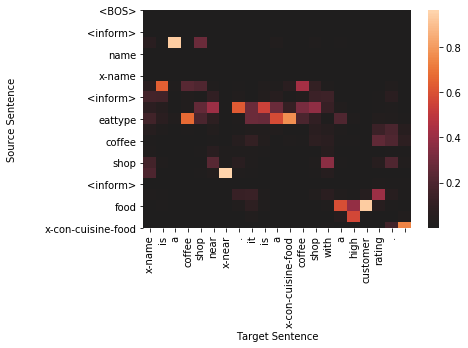

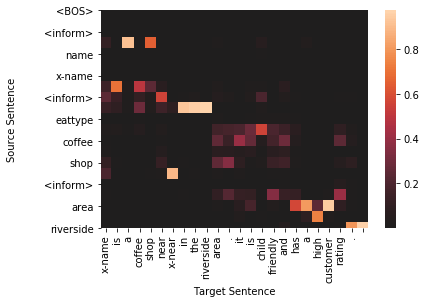

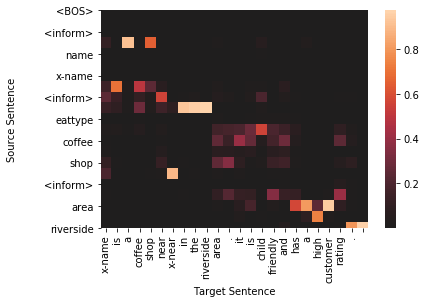

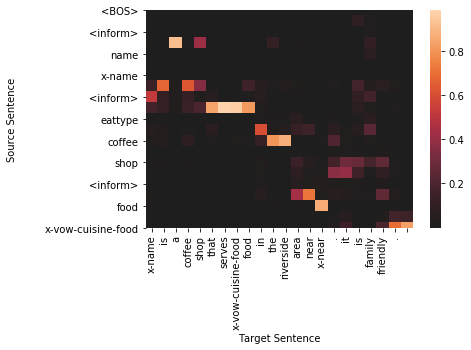

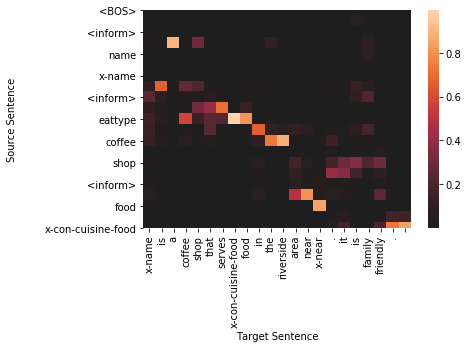

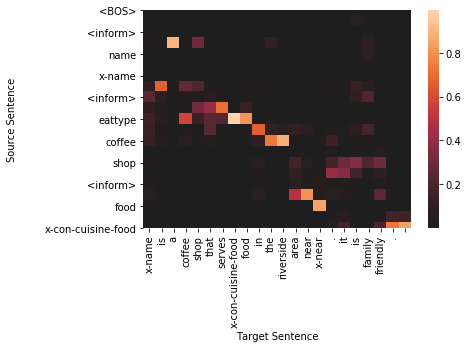

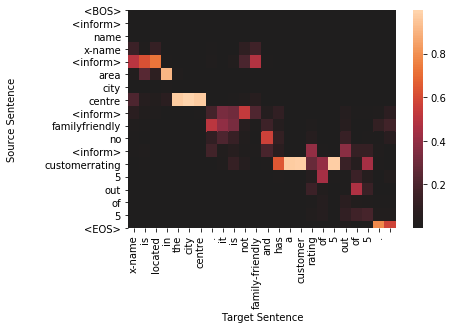

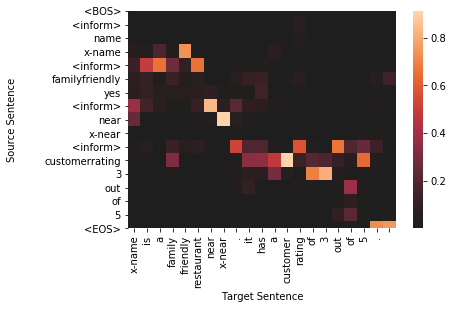

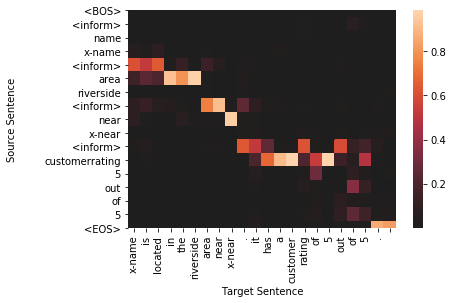

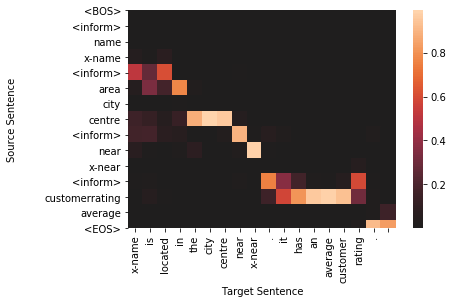

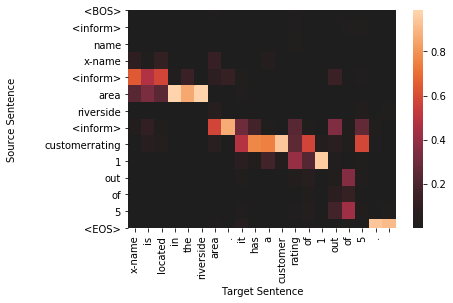

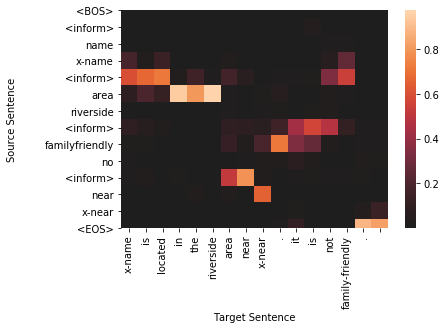

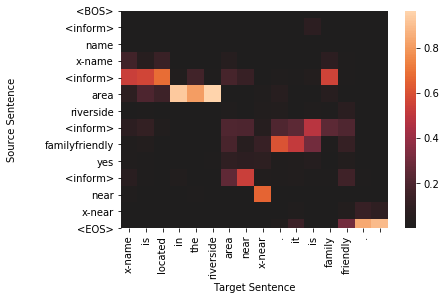

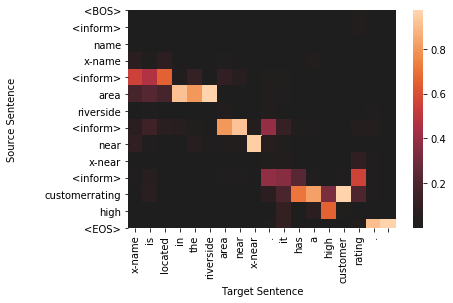

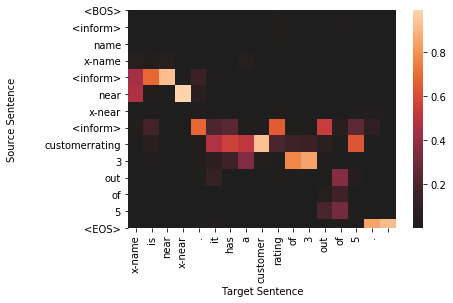

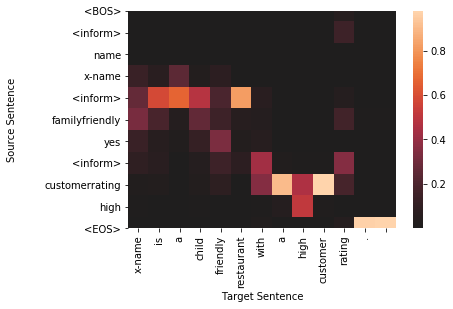

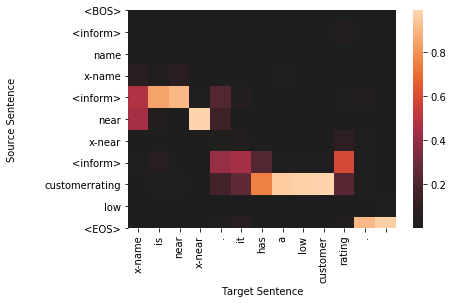

In [38]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")

In [39]:
for result in all_results:
    print("MR GT: ")
    print(result["mrs_gt"])
    print("------------------")
    print("Input MR: ")
    print(result["source"])
    print("-------------------------")
    print("Reference ground truth: ")
    print(result["reference_gt"])
    print("---------------------------")
    print("Sampled no delexicalization: ")
    print(result["sampled_normalized"])
    print("---------------------------")
    print("Sampled with delexicalization: ")
    print(" ".join(result["sampled"]))
    print("---------------------------")
    print("Bleu")
    print(result['bleu-4'])
    print("############################")


MR GT: 
name[The Eagle], eatType[coffee shop], food[Chinese], priceRange[cheap], customer rating[5 out of 5], area[city centre], familyFriendly[yes], near[Burger King]
------------------
Input MR: 
['<inform>', 'name', 'x-name', '<inform>', 'eattype', 'coffee', 'shop', '<inform>', 'food', 'x-con-cuisine-food', '<inform>', 'pricerange', 'cheap', '<inform>', 'area', 'city', 'centre', '<inform>', 'familyfriendly', 'yes', '<inform>', 'near', 'x-near', '<inform>', 'customerrating', '5', 'out', 'of', '5']
-------------------------
Reference ground truth: 
There is a cheap coffee shop named The Eagle located in the city centre near the Burger King . This family friendly establishment serving Chinese food has a rating of 5 out of 5 . 
---------------------------
Sampled no delexicalization: 
The Eagle is a cheap Chinese coffee shop near Burger King in the city centre . it is family-friendly . it has a customer rating of 5 out of 5 . 
---------------------------
Sampled with delexicalization: 


In [12]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'], 
                   sample_probability=1.0)
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

results = get_all_sentences(vectorizer, batch_dict, 30)
results

Inputs are equal
True
After embedding
True
The outputs of the last layer
True
The last hidden states
True
Hidden states are equal after the map
True
After taking the target embeddings: 
True
Before taking the GRU step: 
True
After taking a GRU step: 
True
After going through the attention: 
True
After running the classifier: 
True
After going the softmax layers: 
True
torch.Size([32, 2894])
After taking the index of the predicted word: 
True
torch.Size([32])
#######################################
After taking the target embeddings: 
True
Before taking the GRU step: 
True
After taking a GRU step: 
True
After going through the attention: 
True
After running the classifier: 
True
After going the softmax layers: 
True
torch.Size([32, 2894])
After taking the index of the predicted word: 
True
torch.Size([32])
#######################################
After taking the target embeddings: 
True
Before taking the GRU step: 
True
After taking a GRU step: 
True
After going through the attention: 


{'source': '<inform> name x-name <inform> area riverside <inform> familyfriendly no',
 'truth': 'x-name , located on the river . no good for families . ',
 'sampled': 'x-name is located in the riverside area . it is not family-friendly . '}